2017-06
Mel Rose
meljulerose@gmail.com

# Set up/Load

## imports and functions

In [431]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import Image, display
from IPython.display import Javascript
import numpy as np
import os, glob, subprocess, time, psutil
import pandas as pd
from mirpy import miriad 
# note: mirpy is a python2 module that I futurized
# so I could use it in python3

# takes mir_output from uvsplit and return the names of the new files
def names_uvsplit(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[2:]
    temp = [t.split(' ')[-1] for t in tmp]
    return(temp)
    

# takes mir_output from uvsplit and return the names of the new files
def grabrms_invert(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'rms' in j:
            return(j.split(': ')[-1])


def kill(proc_pid):
    process = psutil.Process(proc_pid)
    for proc in process.children(recursive=True):
        proc.kill()
    process.kill()
        
def move_and_display_pngs(device,dir_name,log, display_results):
    png_names = device.replace('/png','*')
    plot_list = glob.glob(png_names)
    
    if display_results:
        for plot in plot_list:
            display(Image(filename=plot, format='png'))

    # rm them if they already exist
    !rm $dir_name/$png_names
    !mv $png_names $dir_name
    if log: 
        !mv $log $dir_name
        
        
def log_it(log_name, introduction, mir_output):
    with open(log_name, "a") as myfile:
        myfile.write("-"*10+" {0} ".format(introduction)+"-"*10)
        myfile.write("\n \n {0} \n \n ".format(mir_output.decode("utf-8", errors="replace")))
        
        
# issue a warning if pgflags more than 50% of the data
def flaggingcheck_pgflag(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[-1].split('%')[0]
    tmp = float(tmp)
    if tmp >= 50:
        warning = '!'*500 + 'Warning! You are flagging {0}% of the data, which is a lot'.format(tmp)+'!'*500
    else:
        warning=''
    return([tmp, warning])


# check if the rms decreases with each iteration
def rmscheck_clean(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[2:]
    
    min_arr = []
    max_arr = []
    rms_arr = []
    iter_arr = []
    flux_arr = []
    for k, j in enumerate(tmp):
        if 'rms' in j:
            temp = j.split(': ')[-1].split('  ')
            min_arr.append(temp[1])
            max_arr.append(temp[2])
            rms_arr.append(temp[3])
        elif 'Iterations' in j:
            iter_arr.append(j.split(': ')[-1])
        elif 'flux' in j:
            flux_arr.append(j.split(': ')[-1])
    
    # check that the rms is monotonically decreasing
    dx= np.diff(np.asarray(rms_arr,dtype=float))
    all_decreasing = np.all(dx <= 0)
    
    if not all_decreasing:
        culprit = iter_arr[np.argmax(dx>0)]
        print("Warning: RMS values are not monotonically decreasing after {0} iterations".format(culprit))
        
    
    # get a visual 
    '''
    plt.title("Total Cleaned Flux")
    plt.plot(iter_arr, flux_arr)
    plt.xlabel('Iterations')
    plt.ylabel('Flux')
    plt.show()
    '''
    
    plt.title("Residual RMS")
    #plt.plot(iter_arr, min_arr, label="min")
    #plt.plot(iter_arr, max_arr, label="max")
    plt.plot(iter_arr, rms_arr, label="rms")
    
    if not all_decreasing:
        plt.axvline(x=float(culprit), linestyle="--")
        
        
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('Iterations')
    plt.ylabel('Flux')
    plt.show()
    
# grab the peak flux value
# returns [peak value, error]
def grabrms_imhist(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'rms' in j:
            temp = tmp[k+1].split(' ')
            ret = [t for t in temp if t !='']
            return(ret[2])

def grabflux_uvfmeas(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'Scalar' in j:
            temp = tmp[k].split(' ')
            ret = [t for t in temp if t !='']
            return(float(ret[3]))


# grab the peak flux value
# returns [peak value, error]
def grabpeak_imfit(mir_output):
    tmp = mir_output.decode("utf-8", errors="replace").split("\n")[2:]
    for k, j in enumerate(tmp):
        if 'Peak' in j:
            temp = j.split(': ')[-1].split(' ')
            ret = [t for t in temp if t !='']
            return(ret[::2])
        
def check_ifreduced(notebook_dir):
    filenames = glob.glob(notebook_dir+'/*.html')
    files = [file.split('_scripts/')[-1].split('_')[0] for file in filenames]
    return(files)

# save as HTML
# I also had to install nbconvert
# conda install nbconvert
# conda install -c conda-forge jupyter_contrib_nbextensions
def export_to_html(filename,source):
    save_as = notebook_dir+'/'+source+'_reduction.html'
    print(save_as)
    !rm $save_as
    rename_cmd = filename.replace(".ipynb", ".html") + ' ' + save_as
    print(rename_cmd)
    cmd = 'jupyter nbconvert --to html_embed --template toc2 {0}'.format(filename)
    print(cmd)
    subprocess.call(cmd, shell=True)
    !mv $rename_cmd
    return(source+'_reduction.html')


def save_notebook():
    display(Javascript("IPython.notebook.save_notebook()"),
                   include=['application/javascript'])
    return display(Javascript("IPython.notebook.create_checkpoint()"),
                   include=['application/javascript'])

## loading the data

In [29]:
# checking the contents of the directory we're in 
notebook_dir = os.getcwd()
os.chdir("/Volumes/mjrose media/ASTRON data/L_test")
cwd = os.getcwd()
infiles = glob.glob('*')
print(infiles)

['0022-423.1332', '0022-423.1844', '0022-423.2100', '0022-423.2356', '0022-423.2868', '0022-423.2868.ibeam', '0022-423.2868.imap', '0022-423.2868.imodel', '0022-423.2868.iresidual', '0022-423.2868.irestor', '0022-423.uvaver.2100', '0023-263.1332', '0023-263.1844', '0023-263.2100', '0023-263.2356', '0023-263.2868', '0023-263.2868.ibeam', '0023-263.2868.imap', '0023-263.2868.imodel', '0023-263.2868.iresidual', '0023-263.2868.irestor', '0023-263.uvaver.2100', '0741-063.1332', '0741-063.1844', '0741-063.2100', '0741-063.2356', '0741-063.2868', '0741-063.2868.ibeam', '0741-063.2868.imap', '0741-063.2868.imodel', '0741-063.2868.iresidual', '0741-063.2868.irestor', '0741-063.uvaver.2100', '0743-673.2100', '0823-500.2100', '0834-196.1332', '0834-196.1844', '0834-196.2100', '0834-196.2356', '0834-196.2868', '0834-196.2868.ibeam', '0834-196.2868.imap', '0834-196.2868.imodel', '0834-196.2868.iresidual', '0834-196.2868.irestor', '0834-196.uvaver.2100', '0859-140.1332', '0859-140.1844', '0859-140.2

In [14]:
# load in the data 

loadeduv = "loaded.uv"

# atlod parameters
in_ = infiles #"2015-04-11_0513.C3030"#"2015-04-11_0149.C3030"#infiles 
out= loadeduv
ifsel=1
options = 'birdie,rfiflag,noauto,xycorr'

# remove uvdata if it already exists
!rm -r $out

# store miriad output in variable in case you want to parse it
mir_output = miriad.atlod(in_=in_, out=out, ifsel=ifsel, options=options)

# but let's take a look at it
print(mir_output.decode("utf-8"))


# flag the edge channels that are within the bandpass rollof

# uvflag parameters
vis = loadeduv
edge = 40
flagval = "flag"

mir_output = miriad.uvflag(vis=vis, edge=edge, flagval=flagval)
print(mir_output.decode("utf-8"))

# split the dataset into its component sources:

if cwd.split('/')[-1] == 'L_test':    # 
    suffix = '.2100'             #
elif cwd.split('/')[-1] == 'CX': #
    suffix = '.5500'             #
     

# uvsplit parameters
vis = loadeduv

# remove vis if it already 
!rm -r *$suffix

mir_output = miriad.uvsplit(vis=vis)
print(mir_output.decode("utf-8"))

rm: loaded.uv: No such file or directory
atlod: Revision 1.53, 2016/08/25 23:02:21 UTC

Processing file 2015-04-11_0149.C3030
 01:43:36 CAOBS> set file c3030_targets_mos
 01:49:05 CAOBS> set file c3030_cal
 01:49:14 CAOBS> track 1
CABB data detected
Scan 1 started at 15APR11:01:49:34.9
Source: 1934-638
Flagging channels in  28 frequency ranges
 01:55:26 CAOBS> stop
 01:55:43 CAOBS> set file c3030_targets_mos
 01:55:50 CAOBS> start 1/99
Scan 2 started at 15APR11:01:56:35.7
Source: pks1934-638
Source: pks1740-649
Source: pmnj1726-6427
Source: pks1814-637
Source: mwacsj2153.5
Source: pks2149-28
Source: pks2135-209
Source: mwacsj2157.5
Source: pks2254-367
Source: 2311-452
Source: pks2333-528
Source: 0022-423
Source: mwacsj2352.4
Source: 0023-263
Scan 3 started at 15APR11:02:32:45.7
Source: pks1934-638
Source: pks1740-649
Source: pmnj1726-6427
Source: pks1814-637
Source: mwacsj2153.5
Source: pks2149-28
Source: pks2135-209
Source: mwacsj2157.5
Source: pks2254-367
Source: 2311-452
Source: pks

In [15]:
# split the dataset into its component sources:

if cwd.split('/')[-1] == 'L_test':    # 
    suffix = '.2100'             #
elif cwd.split('/')[-1] == 'CX': #
    suffix = '.5500'             #

# for this data set I need to order the sources 
# so each can be the phase calibrator for the next
notebook_dir = "/Users/mmcintosh/Dropbox/ASTRON2017/data_reduction_scripts"

# get a full list of ordered sources
blocks = np.arange(1,11,1)
temp_arr = []
for block in blocks: 
    temp_txt = np.loadtxt(notebook_dir+"/c3030_block{0}.mos".format(block), dtype=bytes)
    temp_arr.append([t[-1].decode('UTF-8')[1:].lower() for t in temp_txt])

# get the unique blocks    
unique_blocks = np.sort(np.unique(temp_arr, return_index=True)[1])
sources = np.concatenate([temp_arr[index] for index in unique_blocks])
sources = [s+suffix for s in sources]
# the first is the bandpass calibrator, which we'll work on seperately
bandflux_cal = sources[0]
#print(sources)

# some are repeated but they are in the order we need for phase calibration

# init a dataframe to keep track of phasecals
df_path = 'bright_enough.csv'
df_init = pd.DataFrame({'name' : sources, 'percent_flagged': '?', 'flux' : '?', 'phasecal':'?'})
df_init.append(df)
df_init.to_csv(df_path)

# Bandpass Calibration

## Precalibration Images

In [22]:


# get an idea of what the data looks like before calibration
print('#'*10+"Pre mfcal bandpass, flux calibration"+'#'*10)
# remove files if ran previously 
!rm *png* 
# uvspec parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "chan,amp"
device="{0}bfpremfcal.png/png".format(vis)
# can do devices like /xs, /png, /null, or others listed on the link:
# (http://www.atnf.csiro.au/computing/software/miriad/userguide/node25.html)
# note: you have to close xs before the cell stops hanging
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}bfpremfcal*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))


##########Pre mfcal bandpass, flux calibration##########


KeyboardInterrupt: 

In [ ]:
# determine the bandpass shape

# mfcal parameters
vis = bandflux_cal

mir_output = miriad.mfcal(vis=vis)
print(mir_output.decode("utf-8"))

# if you want to see what it looks like after mfcal
print('#'*10+"Post mfcal bandpass, flux calibration"+'#'*10)
# delete old ones
!rm *png*
# uvspec parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "chan,amp"
device="{0}bfpostmfcal.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}bfpostmfcal*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))

## RFI flagging

In [ ]:

## RFI FLAGGING

# do this 2 or 3 times
loop = [0,1,3]

for l in loop: 

    # automatic flagging

    # loop through stokes parameters

    stokes_arr = ['xx','xy','yx','yy']

    for u in stokes_arr:
        # pgflag parameters
        vis = bandflux_cal
        stokes = str(u)+','+','.join(stokes_arr)
        command = "<b"
        device="/xs" 
        options="nodisp"
        mir_output = miriad.pgflag(vis=vis,stokes=stokes,command=command,
                            options=options, device=device)
        print(mir_output.decode("utf-8"))
        flaggingcheck_pgflag(mir_output)

    # if you want to see what it looks like after pgflag
    print('#'*10+"Post pgflag bandpass, flux calibration"+'#'*10)
    !rm *png*
    # uvspec parameters
    vis = bandflux_cal
    stokes = "xx,yy"
    axis = "chan,amp"
    #device="/xs"
    device="{0}bfpostpgflag.png/png".format(vis)
    mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                                device=device)

    plot_list = glob.glob('{0}bfpostpgflag*png*'.format(vis))
    for plot in plot_list:
        display(Image(filename=plot, format='png'))


    # flag visibilities by hand
    # xquartz will hang unless you use a miriad task to open it, then kill
    # the python script (but leave xquartz open)
    # I've just been ctrl Q-ing the xquartz program (its a bit slower)

    # blflag parameters
    vis = bandflux_cal
    device="/xs" 
    stokes = "xx,xy"
    axis = "chan,amp"
    options='nofqav,nobase'
    mir_output = miriad.blflag(vis=vis,device=device,stokes=stokes,
                               axis=axis,options=options)
    print(mir_output.decode("utf-8"))

    # mfcal parameters
    vis = bandflux_cal

    mir_output = miriad.mfcal(vis=vis)
    print(mir_output.decode("utf-8"))



    print('#'*10+"Post RFI bandpass, flux calibration"+'#'*10)
    !rm *png*
    # look at the amplitude vs time

    # uvplt
    vis = bandflux_cal
    stokes = "xx,yy"
    axis = "time,amp"
    options="nofqav"
    device="{0}bftimeamp.png/png".format(vis)

    mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                              options=options,device=device)
    print(mir_output.decode("utf-8"))

    uvplot_list = glob.glob('{0}bftimeamp*png*'.format(vis))
    for plot in uvplot_list:
        display(Image(filename=plot, format='png'))

        # if above 1 jy, can use as phase cal for the next round
        # last gpcopy (if not, go 2 back); you can tell on blflag plot



In [ ]:
  
# gain calibration over time

# gpcal parameters
vis = bandflux_cal
interval="0.1"
nfbin="4"
options="xyvary"

mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options)
print(mir_output.decode("utf-8"))

    
# look at the  phase vs time
!rm *png*
# uvplt parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "real,imag"
options="nofqav,nobase,equal"
device="{0}bfrealimag.png/png".format(vis)

mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                          options=options,device=device)
print(mir_output.decode("utf-8"))

uvplot_list = glob.glob('{0}bfrealimag*png*'.format(vis))
for plot in uvplot_list:
    display(Image(filename=plot, format='png'))
    


"""# if you want to see what it looks like after all RFI flagging
print('#'*10+"Post pgflag bandpass, flux calibration"+'#'*10)
!rm *png*
# uvspec parameters
vis = bandflux_cal
stokes = "xx,yy"
axis = "chan,amp"
#device="/xs"
device="{0}tmp.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

plot_list = glob.glob('{0}tmp*png*'.format(vis))
for plot in plot_list:
    display(Image(filename=plot, format='png'))
"""

In [ ]:
# uvfmeas!
vis= bandflux_cal
stokes ='i'
line = 'channel,2048,1,1,1'
log = 'uvfmeaslog{0}MHz_{1}'.format(line.split(',')[-2],vis)
device="{0}.png/png".format(log)
feval="2.1"

mir_output = miriad.uvfmeas(vis=vis,stokes=stokes,device=device,line=line,
                            feval=feval,log=log)
print(mir_output.decode("utf-8", errors='replace'))


plot_list = glob.glob("{0}.png".format(log))
for plot in plot_list:
    display(Image(filename=plot, format='png'))

flux_uvfmeas = grabflux_uvfmeas(mir_output) 
if flux_uvfmeas > 1:
    bright_enough = True
else:
    bright_enough = False
    
    
!rm *png*

# source calibration

In [586]:
dim_arr = []

# was the last source brighter than 1 jsky? 
# can you use it to copy calibration solutions over? 
# if false, uses the one before it

# for block 1, these are the ones not brighter than 1 Jy
# 3 (mwacsj2153.5), 11 (mwacsj2352.4.2100), 14 (pks0105-122.2100)
#dim = [3,11,14]
#if h-1 in dim:


# I should really write out to a seperate file which are bright eneough since I skip around so much
# init
df_path = 'bright_enough.csv'
df_init = pd.DataFrame({'name' : sources, 'percent_flagged': '?', 'flux' : '?', 'phasecal':'?'})
df_init.append(df)
df_init.to_csv(df_path)


# to append after you've gotten a full df to add
# df.to_csv(bright_enough.csv, mode='a', header=False)

In [595]:
flux_uvfmeas, source

phasecal_df.set_value(h, 'flux', flux_uvfmeas)
phasecal_df

,flux,name,percent_flagged,phasecal
0,0.493400,pks1934-638.2100,31.481481,?
1,0.445222,pks1740-649.2100,51.851852,?
2,1.629815,pmnj1726-6427.2100,33.796296,?
3,0.722861,pks1814-637.2100,11.574074,?
4,1.509505,mwacsj2153.5.2100,68.518519,?
5,1.231866,pks2149-28.2100,2.314815,?
6,1.565032,pks2135-209.2100,81.018519,?
7,0.528514,mwacsj2157.5.2100,26.388889,?
8,1.500250,pks2254-367.2100,35.648148,?
9,1.000500,2311-452.2100,31.018519,?


In [587]:
phasecal_df = pd.DataFrame.from_csv(df_path)
phasecal_df

,flux,name,percent_flagged,phasecal
0,2.000000,pks1934-638.2100,31.481481,?
1,0.445222,pks1740-649.2100,51.851852,?
2,1.629815,pmnj1726-6427.2100,33.796296,?
3,0.722861,pks1814-637.2100,11.574074,?
4,1.509505,mwacsj2153.5.2100,68.518519,?
5,1.231866,pks2149-28.2100,2.314815,?
6,1.565032,pks2135-209.2100,81.018519,?
7,0.528514,mwacsj2157.5.2100,26.388889,?
8,1.500250,pks2254-367.2100,35.648148,?
9,1.000500,2311-452.2100,31.018519,?


In [591]:
h = 155
j=1
while True:
    potential_phasecal_name = phasecal_df.loc[h-j]["name"]
    potential_phasecal_flux = phasecal_df[phasecal_df.name == potential_phasecal_name].flux.values[0]
    potential_phasecal_percent_flagged = phasecal_df[phasecal_df.name == potential_phasecal_name].percent_flagged.values[0]
    if float(potential_phasecal_flux) > 1.0 and float(potential_phasecal_percent_flagged) < 50.0:
        phasecal_df.set_value(h, 'phasecal', assigned_phasecal_name)
        break
    else:
        j+=1
        if h > j:
            potential_phasecal_name = phasecal_df.loc[h-j]["name"]
            print(potential_phasecal_name)
        else:
            print("you've run out of phasecals to test")
            break

1549-790.2100 is too low at 0.50075
0823-500.2100
0823-500.2100 is too low at 0.5562777777777778
pks0420-62.2100
pks0420-62.2100 is too low at 1.8704351851851853
pks0252-71.2100
pks0252-71.2100 is too low at 1.046773148148148
pks0201-44.2100
good enough
pks0201-44.2100 1.49099537037 42.1296296296


In [504]:
df

,assigned_phasecal,flux,name,percent_flagged,used_phasecal
155,1549-790.2100,,1323-611.2100,,1549-790.2100


In [407]:
# iterate over sources in the block
h=155


limit = len(sources)
print(h,'/',limit)
source = sources[h]
print('source = '+source)    
print(bright_enough)


already_reduced = check_ifreduced(notebook_dir)
# copy over calibration from the last thing you calibrated
if bandflux_cal in source or source in already_reduced:
    found_next = False
    while not found_next:
        h+=1
        source = sources[h]
        found_next = not (source in already_reduced)
        if h < limit:
            next_up = h
        else:
            next_up = "... all are calibrated!"
            break
            
    print("already calibrated, the next up is {0}".format(next_up))
    vis = None
    raise KeyboardInterrupt
elif bright_enough:
    vis = sources[h-1]
else: 
    vis = sources[h-2]
    dim_arr.append(sources[h-1])

print("vis = "+vis)   



display_results = True

155 / 217
source = 1323-611.2100
True
vis = 1549-790.2100


In [408]:
bright_enough=False

In [427]:
# store all pngs and logs in here
dir_name = source +"_reduction"
print(dir_name)
!rm -r $dir_name
!mkdir $dir_name

log_name = dir_name+"/miriadoutput.txt"
!rm $log_name
log_it(log_name,"Miriad Output for {0} on {1} \n \n".format(source,time.strftime("%d/%m/%Y")), "")

1323-611.2100_reduction
rm: 1323-611.2100_reduction/miriadoutput.txt: No such file or directory


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'gpcal':  It is unwise to omit OPTION=QUSOLVE when flux is unknown
  warnings.warn(msg)


gpcal: Revision 1.22, 2016/05/01 22:31:05 UTC

Applying bandpass corrections to 1549-790.2100
Number of antennae: 6
Using leakage parameters from input as initial guess
Reading the data ...
Number of solution intervals: 40
Total visibilities read: 595
Number visibilities accepted: 595
Iter= 1, Amplit/Phase Solution Error:   0.644
Iter= 1, Polarisation Solution Error:   0.005
Iter= 1, Overall Solution Error:        1.360
Iter= 2, Amplit/Phase Solution Error:   0.003
Iter= 2, Polarisation Solution Error:   0.005
Iter= 2, Overall Solution Error:        0.003
Iter= 3, Amplit/Phase Solution Error:   0.002
Iter= 3, Polarisation Solution Error:   0.005
Iter= 3, Overall Solution Error:        0.001
I flux density:   9.2439
Leakage terms:
 Ant 1:Dx,Dy = ( 0.01520, 0.00290),(-0.01528, 0.00193)
 Ant 2:Dx,Dy = ( 0.01515,-0.00445),(-0.01642,-0.00541)
 Ant 3:Dx,Dy = (-0.02090, 0.00511),( 0.01395, 0.00020)
 Ant 4:Dx,Dy = (-0.00379,-0.00095),( 0.00222,-0.00206)
 Ant 5:Dx,Dy = (-0.00793, 0.00372),( 0.0

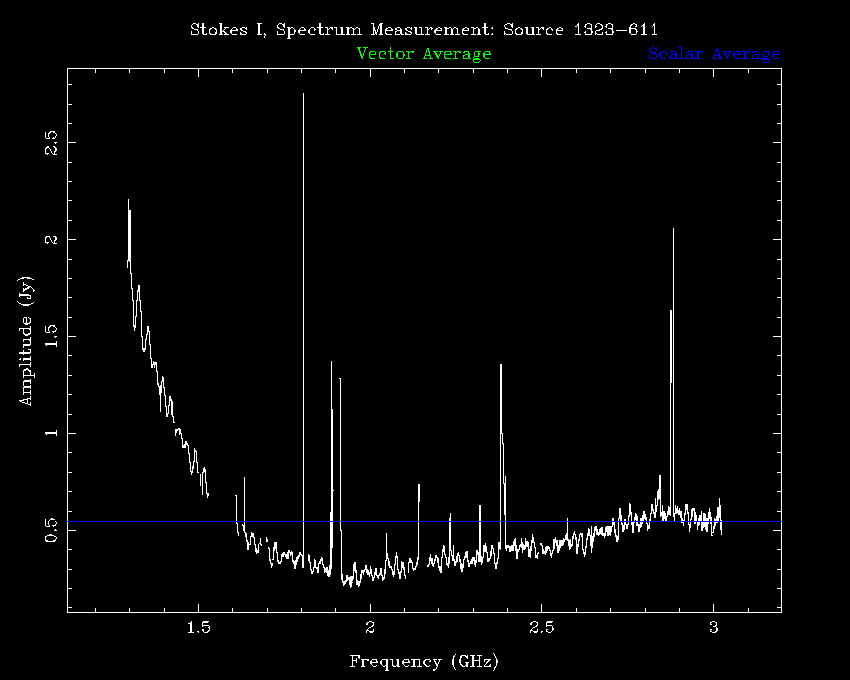

rm: 1323-611.2100_reduction/1323-611.2100_precaluvmeas.png*: No such file or directory


In [410]:
 
# gain calibration over time

# gpcal parameters
interval="0.1"
nfbin="4"
options="xyvary"

mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options)
print(mir_output.decode("utf-8"))

# copy calibration tables from bandpass/flux calibrator to source to be imaged

# gpcopy parameters
out = source

mir_output = miriad.gpcopy(vis=vis,out=out)
print(mir_output.decode("utf-8"))

log_it(log_name,"gpcal", mir_output)



# uvfmeas!
vis= source
stokes ='i'
line = 'channel,2048,1,1,1'
log = 'uvfmeaslog{0}MHz_{1}'.format(line.split(',')[-2],source)
device="{0}_precaluvmeas.png/png".format(source)
feval="2.1"


mir_output = miriad.uvfmeas(vis=vis,stokes=stokes,device=device,line=line,
                             log=log,feval=feval)

log_it(log_name,"uvfmeas", mir_output)
move_and_display_pngs(device,dir_name,log, display_results)



## RFI flagging

pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100
Applying changes to dataset
Counts of correlations within selected channels:
 channel  Originally  Currently
 Good:       1006500     817384    Changed to bad:     189116
 Bad:         345840     534956    Changed to good:         0
 39.6% of the data is now flagged
pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100
Applying changes to dataset
Counts of correlations within selected channels:
 channel  Originally  Currently
 Good:        817384     811628    Changed to bad:       5756
 Bad:         534956     540712    Changed to good:         0
 40.0% of the data is now flagged
pgflag: Revision 1.30, 2016/10/05 23

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'blflag':  Omitting channel specific flags in text file
  warnings.warn(msg)


pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100
Applying changes to dataset
Counts of correlations within selected channels:
 channel  Originally  Currently
 Good:        786752     777000    Changed to bad:       9752
 Bad:         565588     575340    Changed to good:         0
 42.5% of the data is now flagged
pgflag: Revision 1.30, 2016/10/05 23:06:50 UTC

Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100
Applying changes to dataset
Counts of correlations within selected channels:
 channel  Originally  Currently
 Good:        777000     773336    Changed to bad:       3664
 Bad:         575340     579004    Changed to good:         0
 42.8% of the data is now flagged
pgflag: Revision 1.30, 2016/10/05 23

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'blflag':  Omitting channel specific flags in text file
  warnings.warn(msg)


##########Post blflag source##########


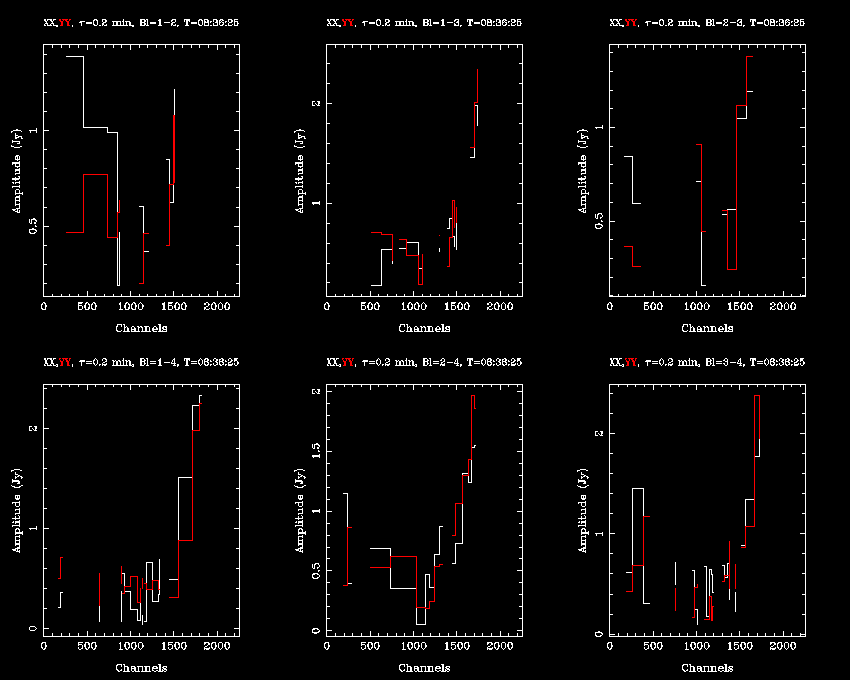

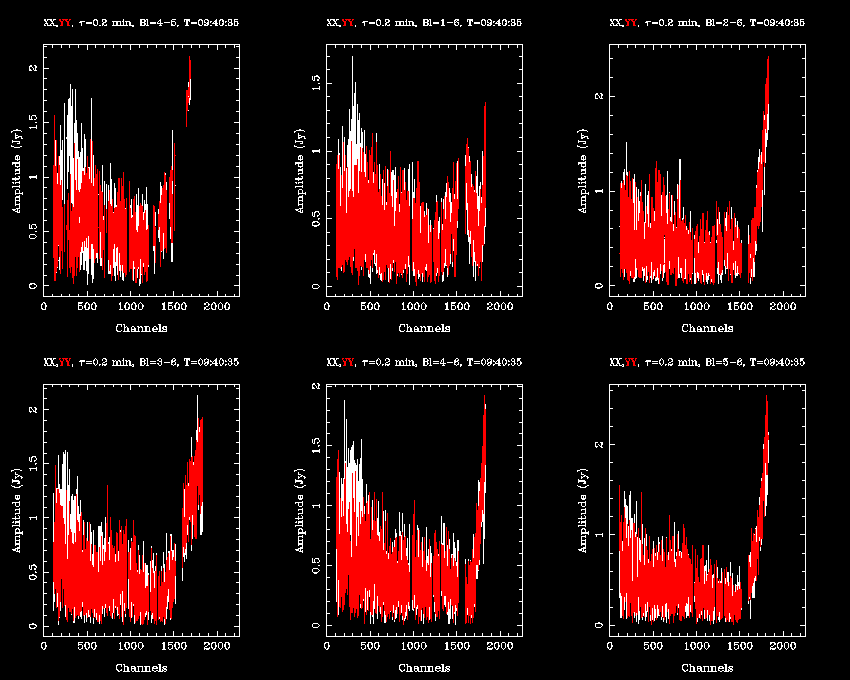

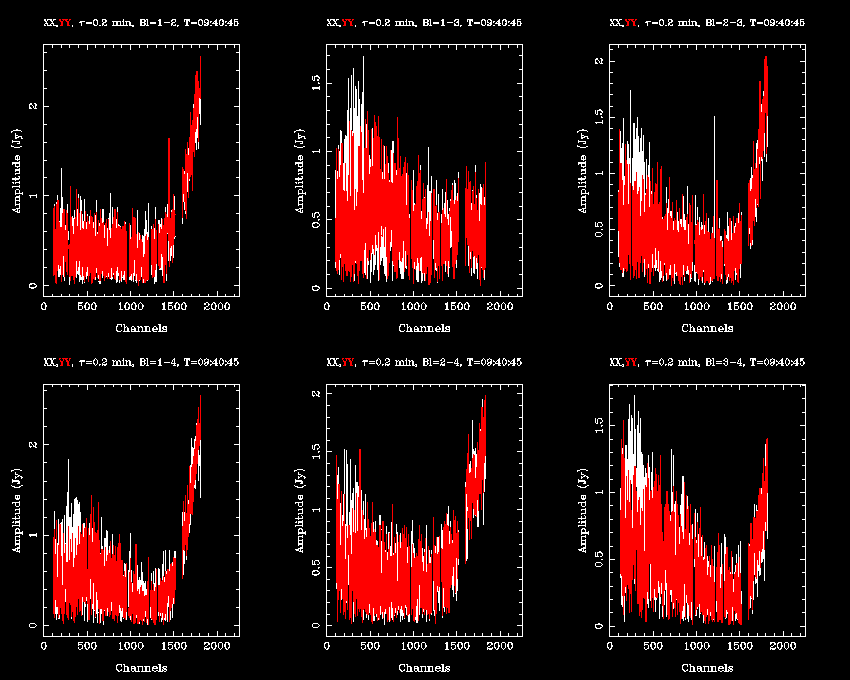

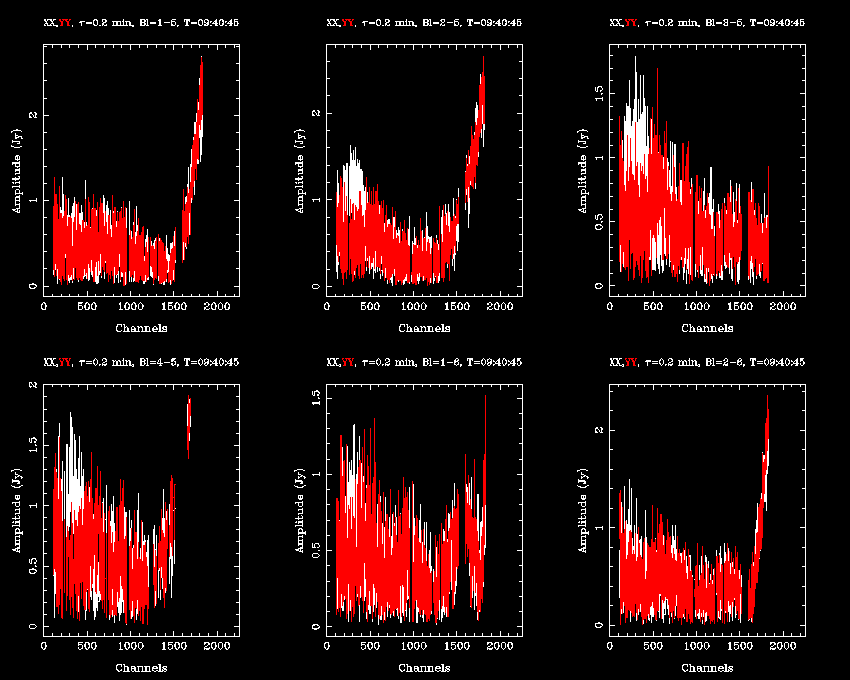

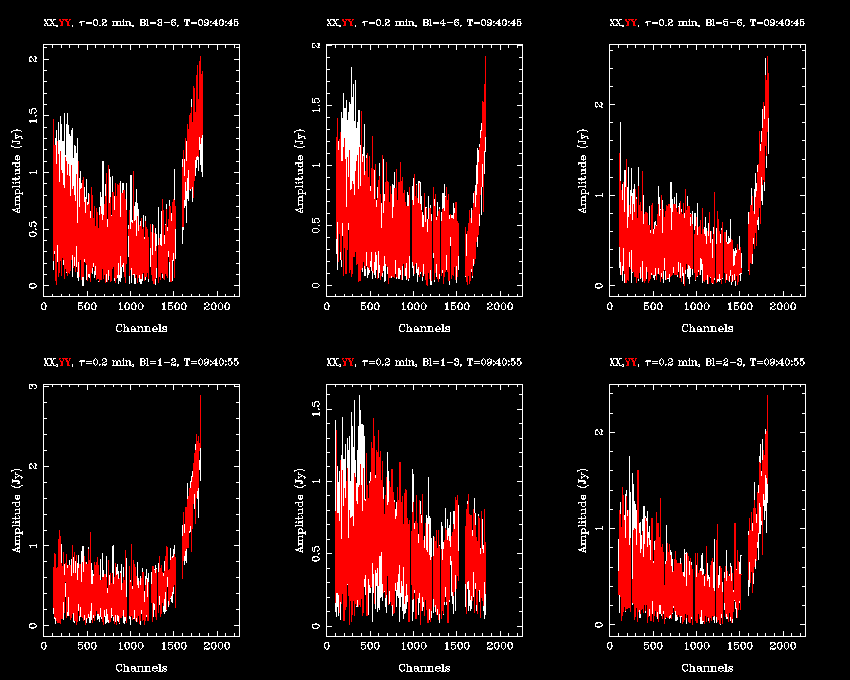

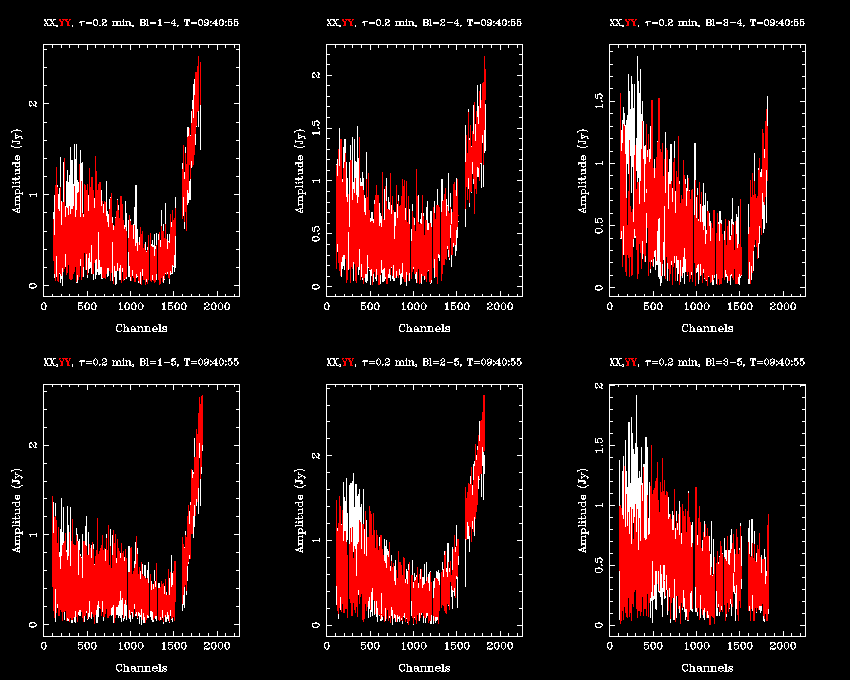

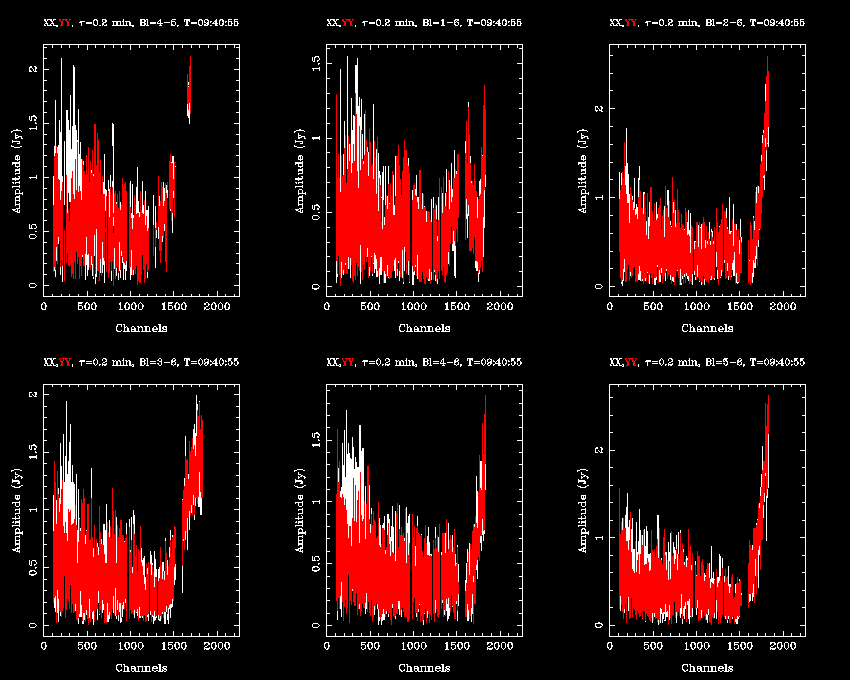

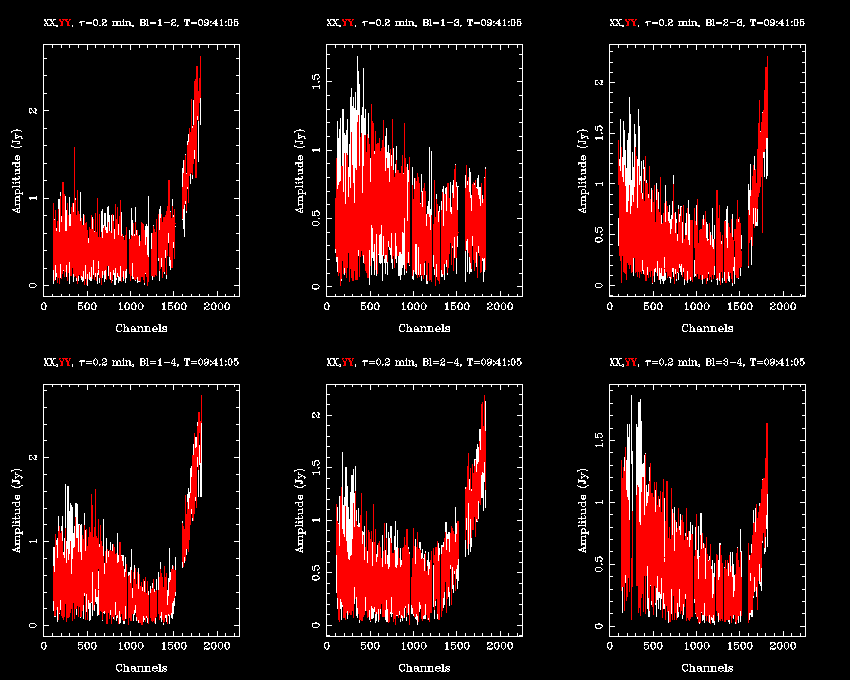

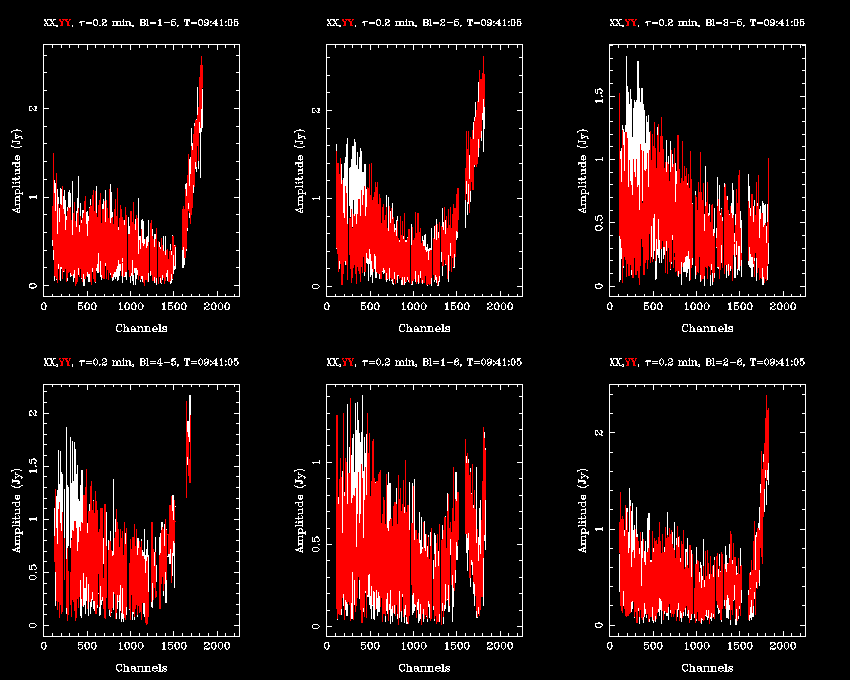

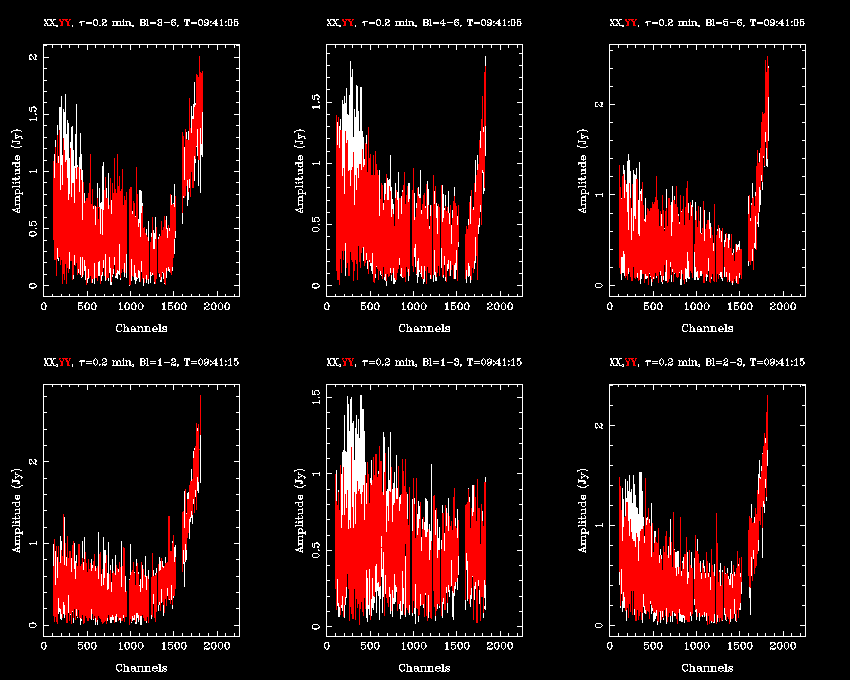

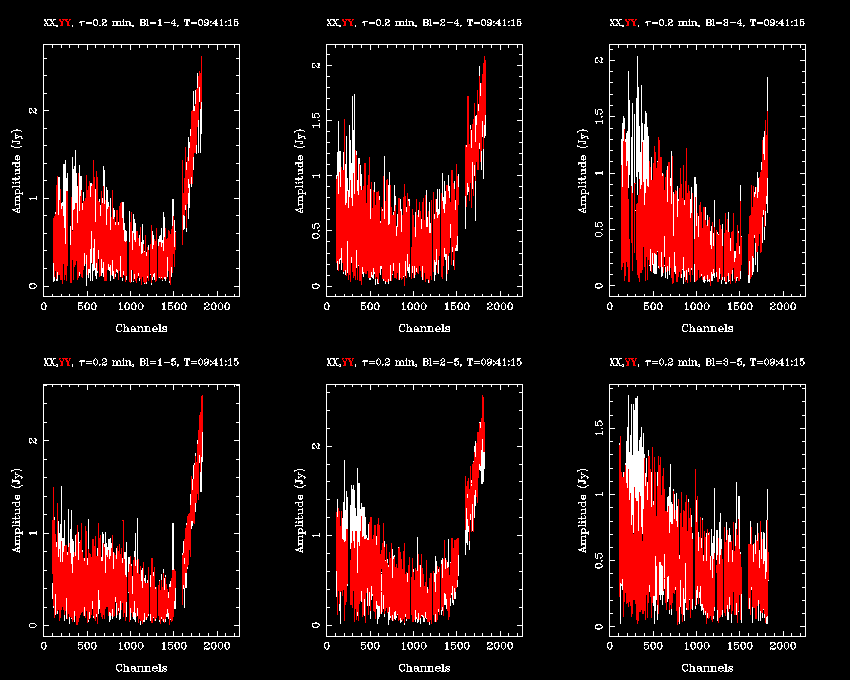

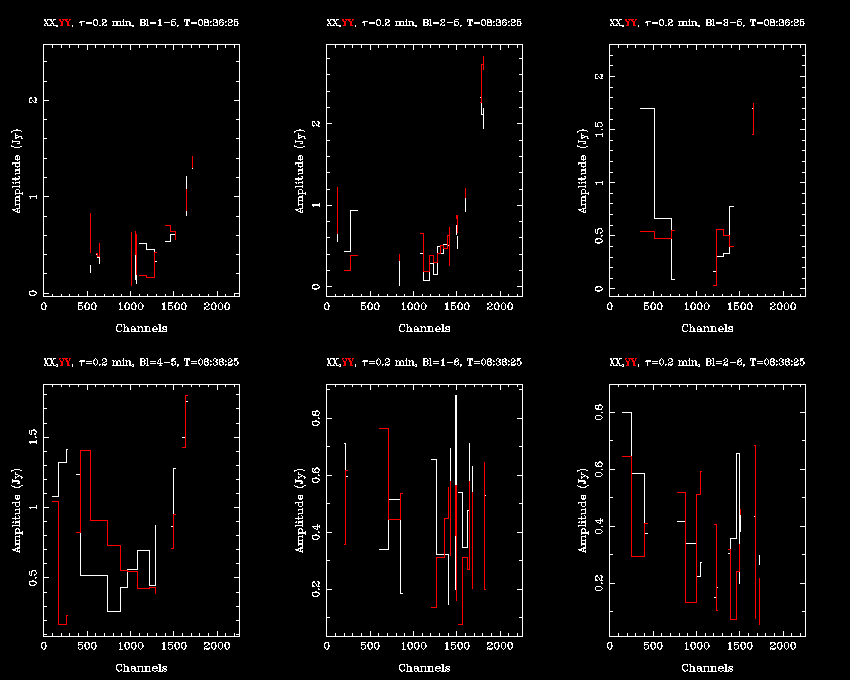

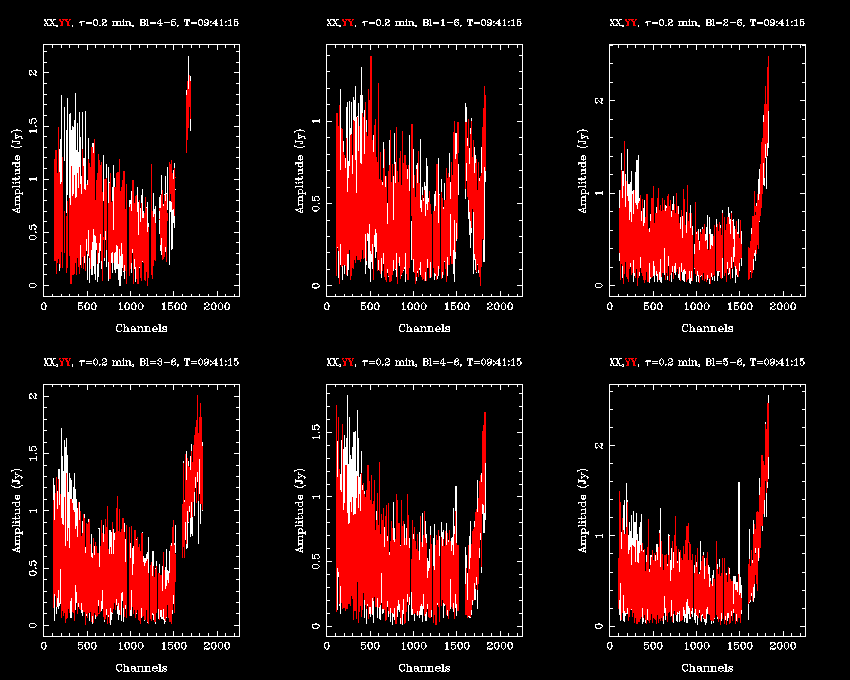

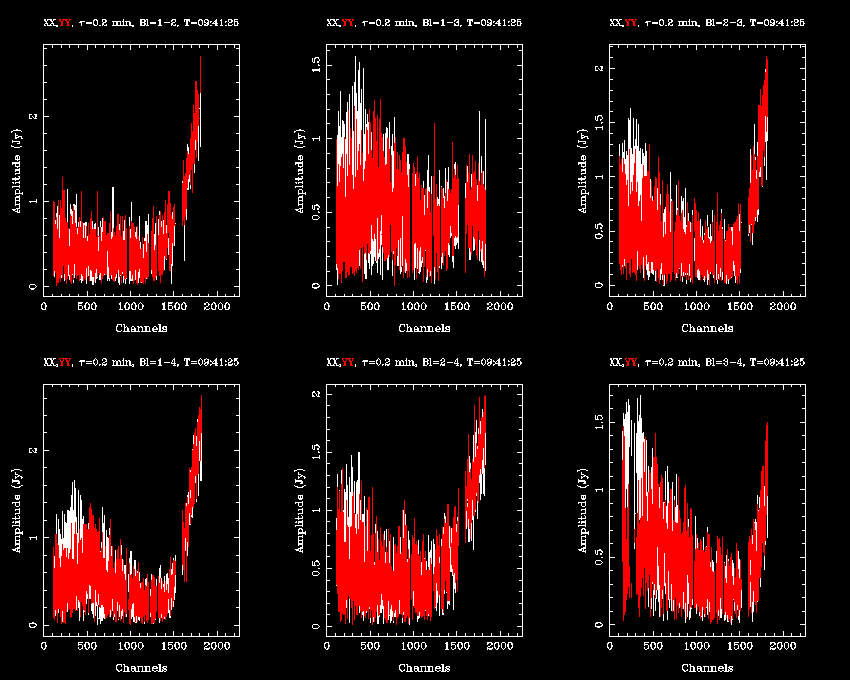

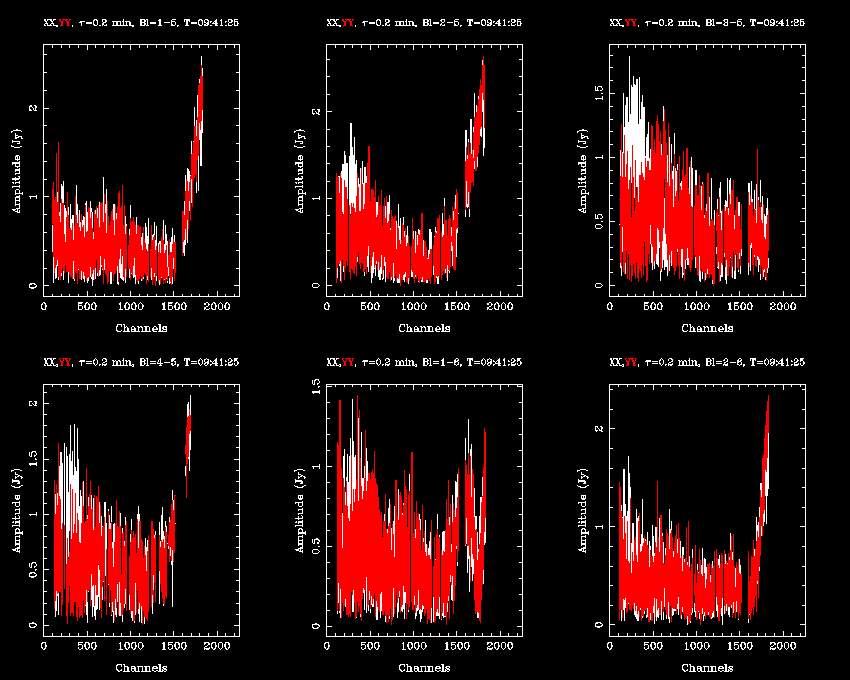

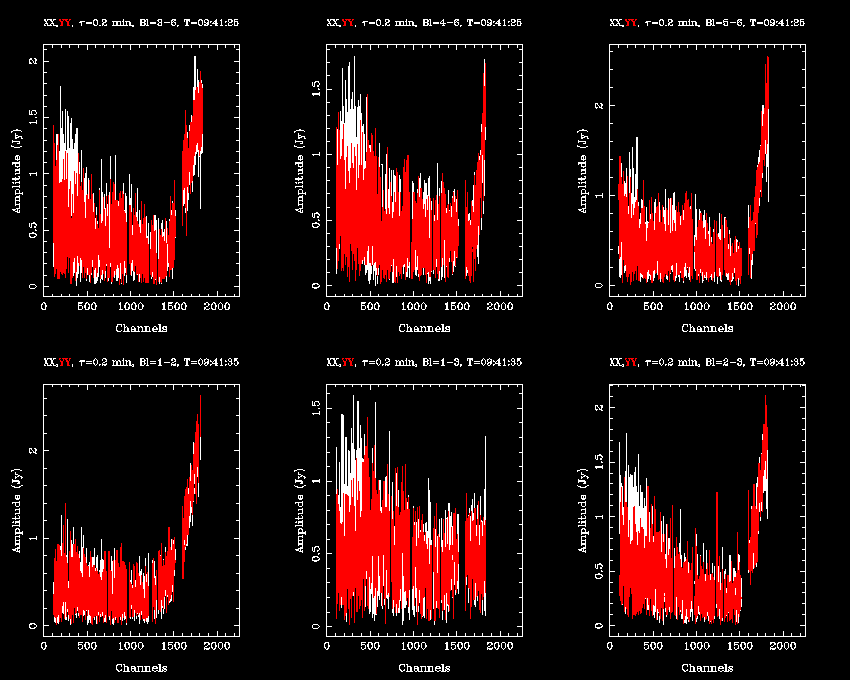

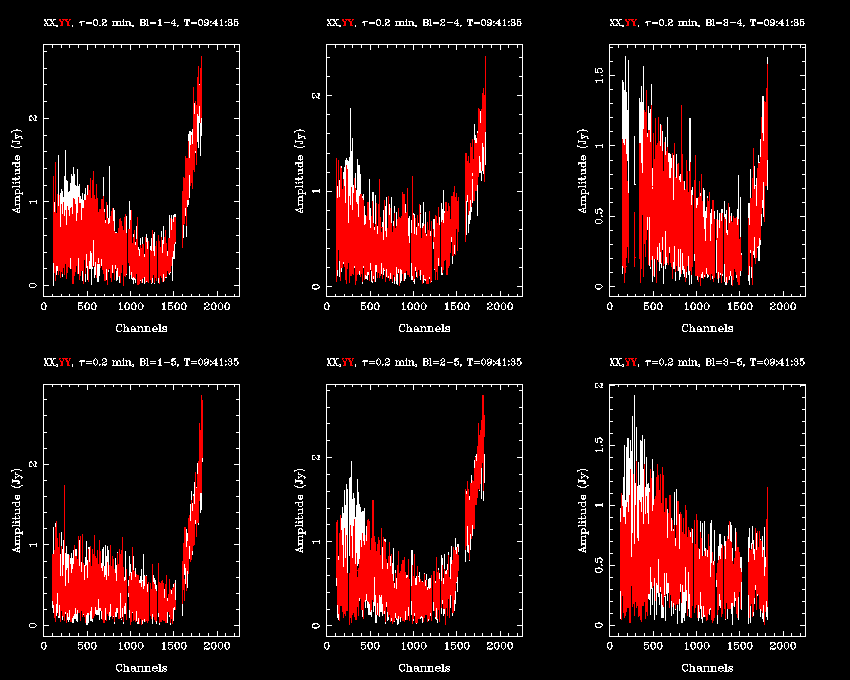

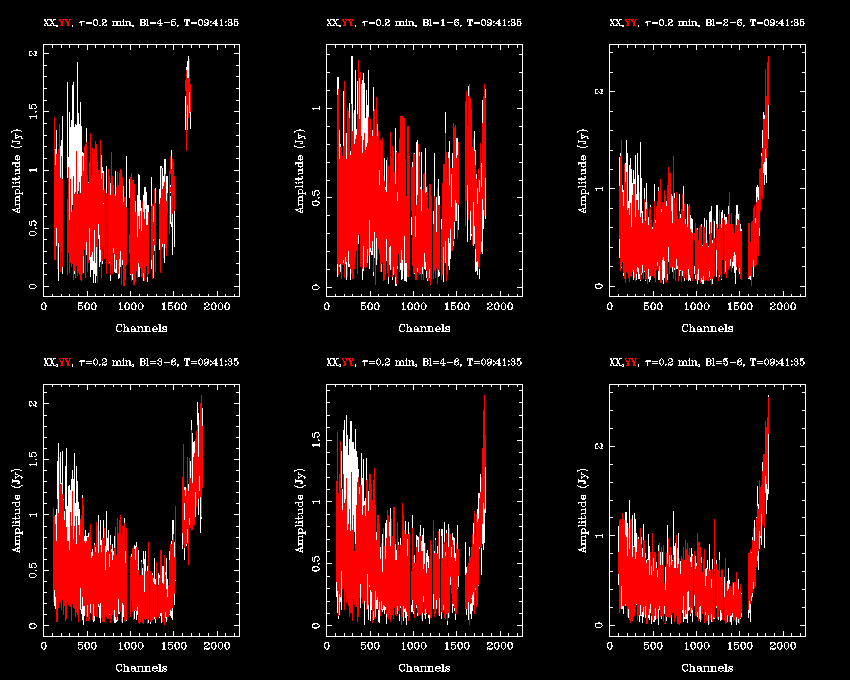

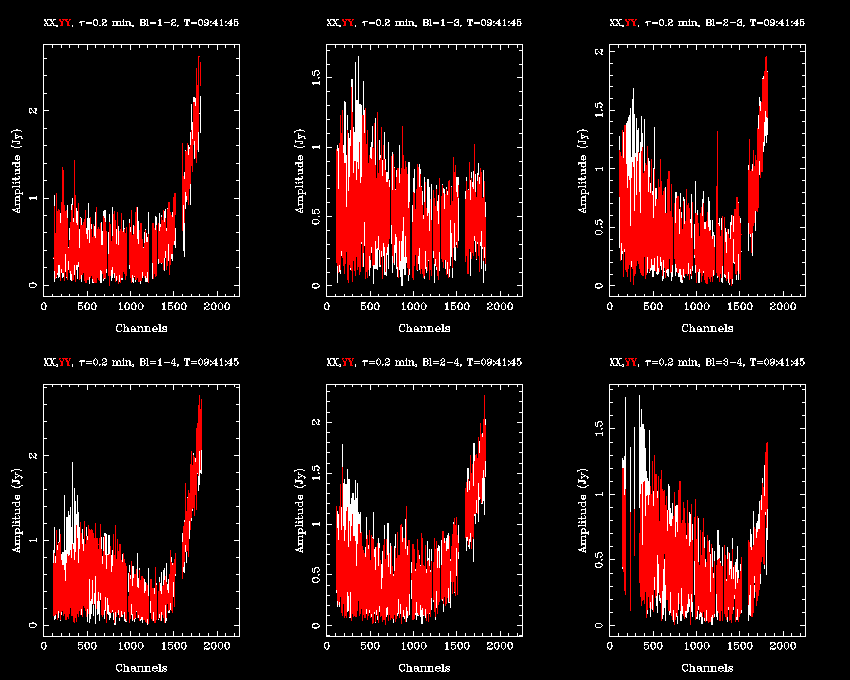

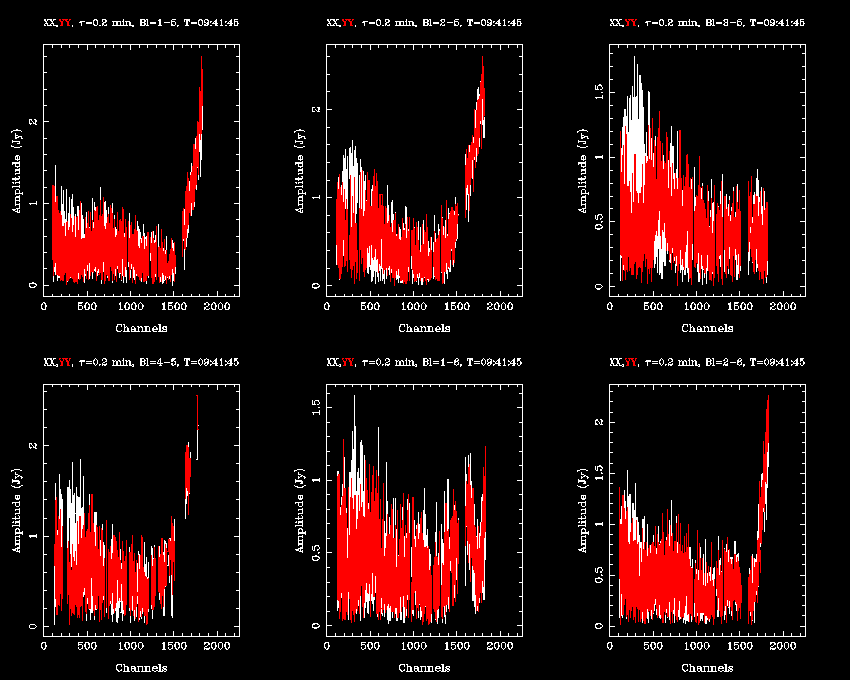

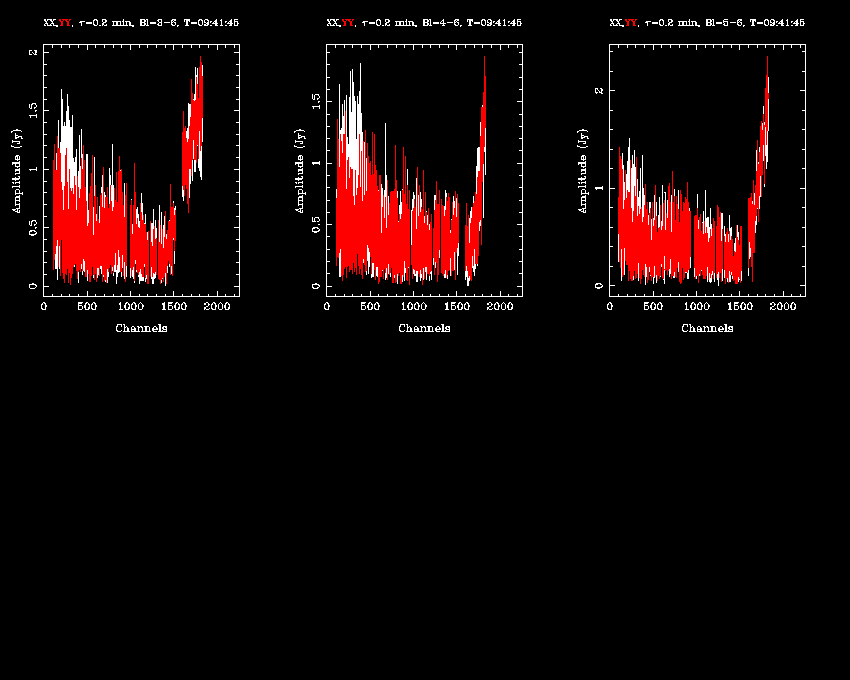

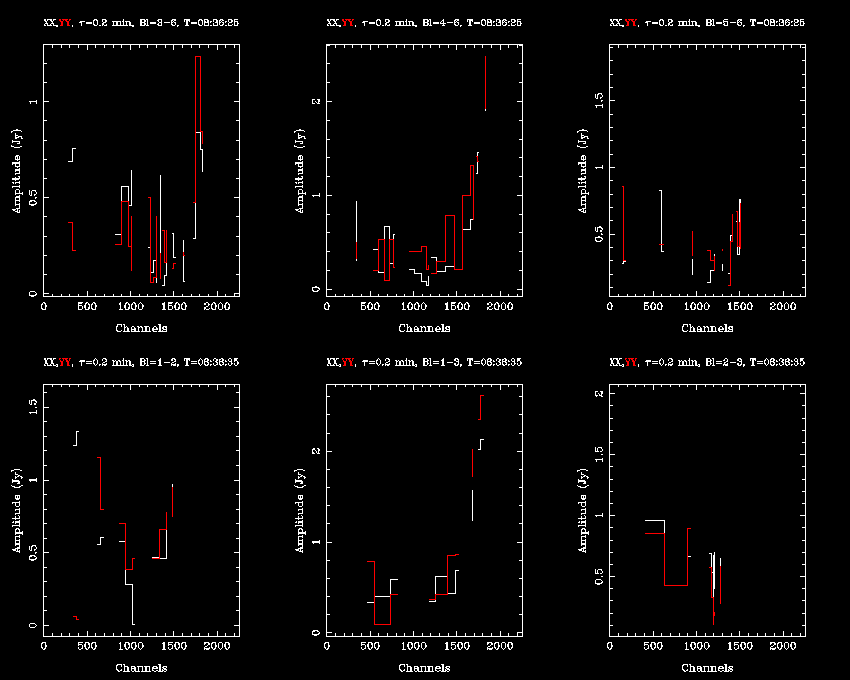

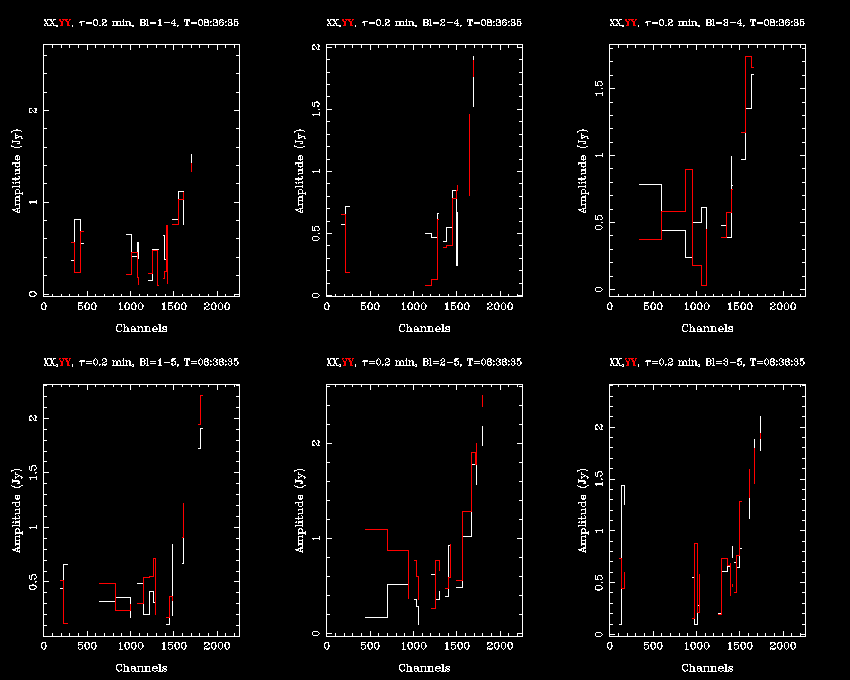

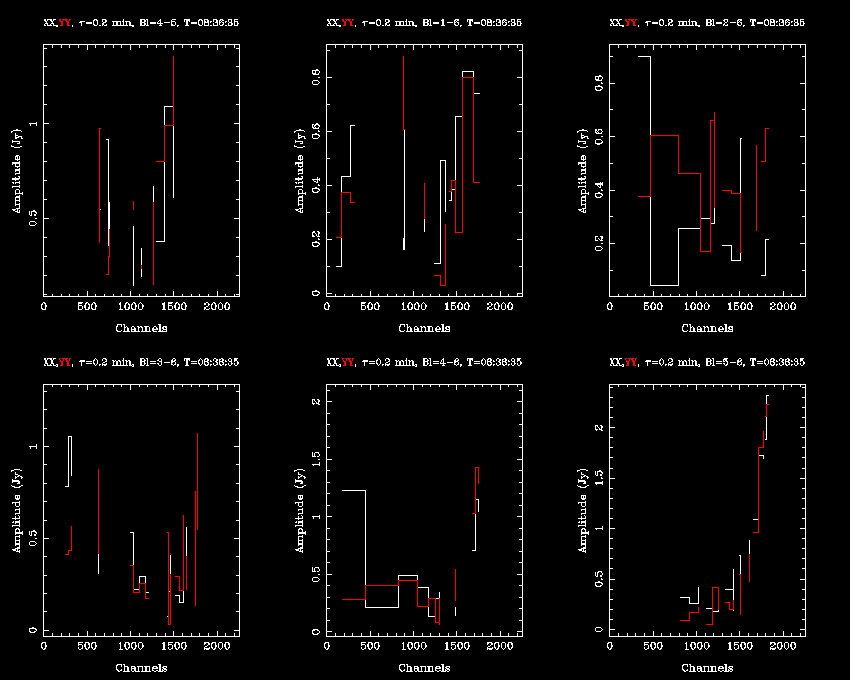

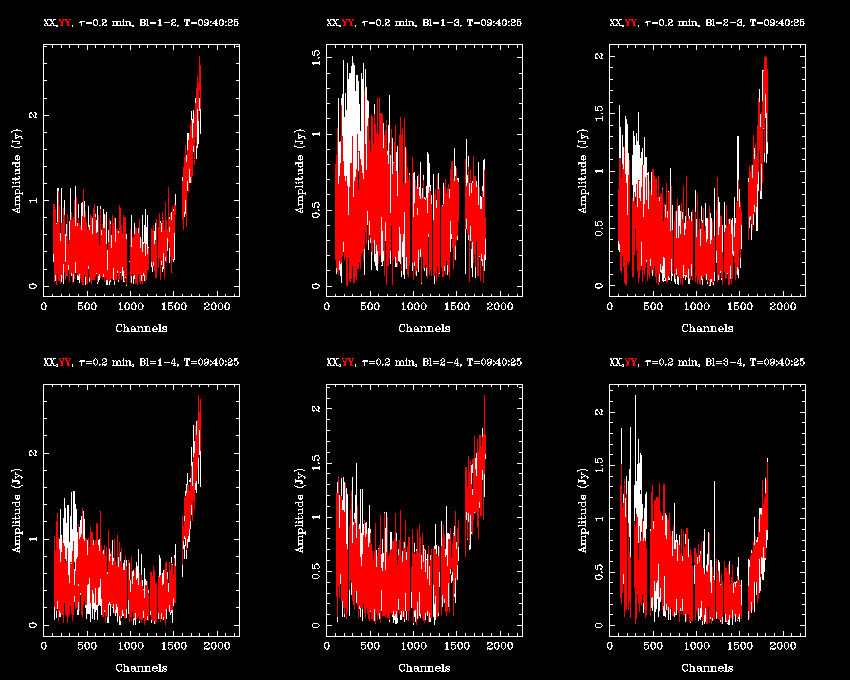

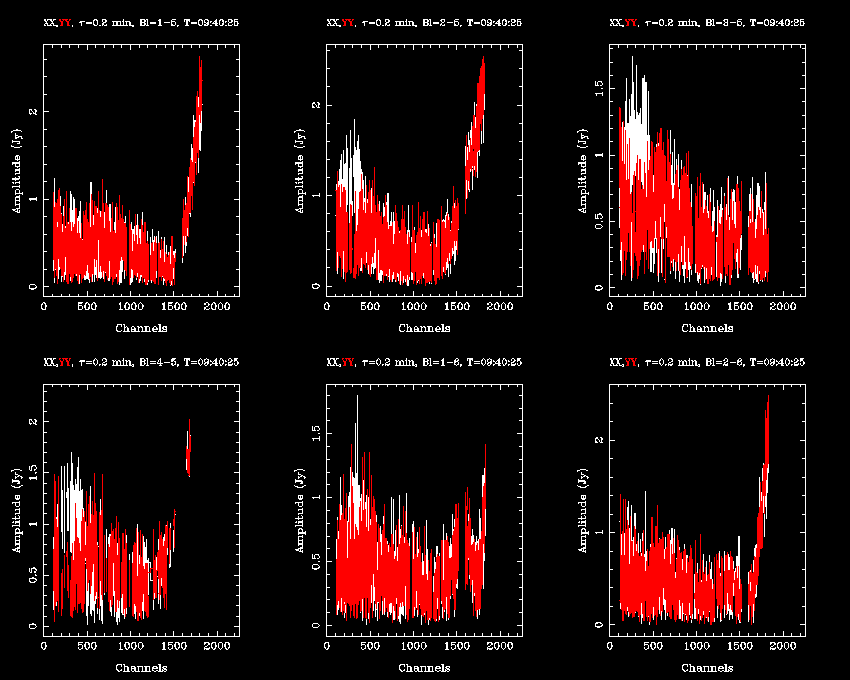

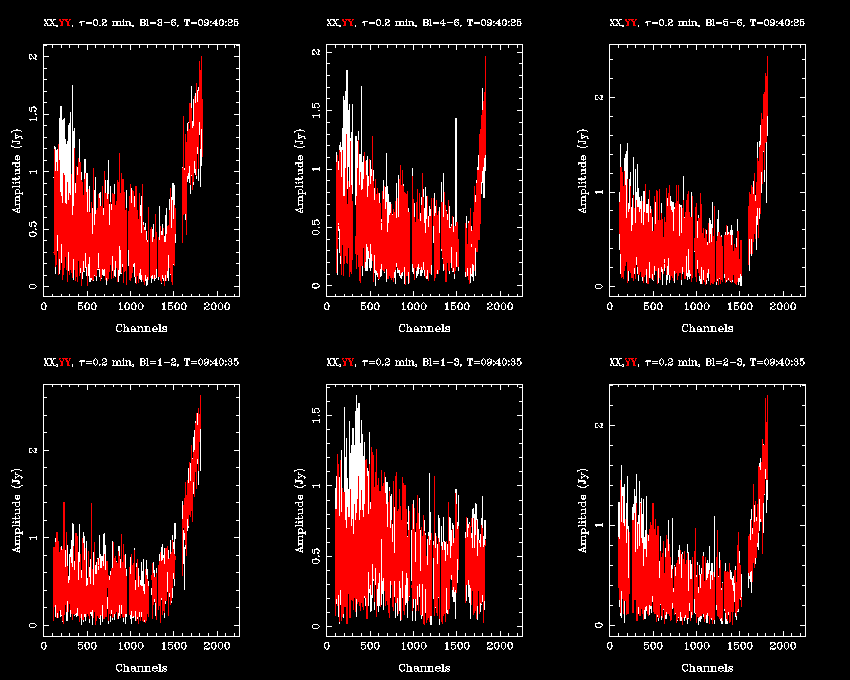

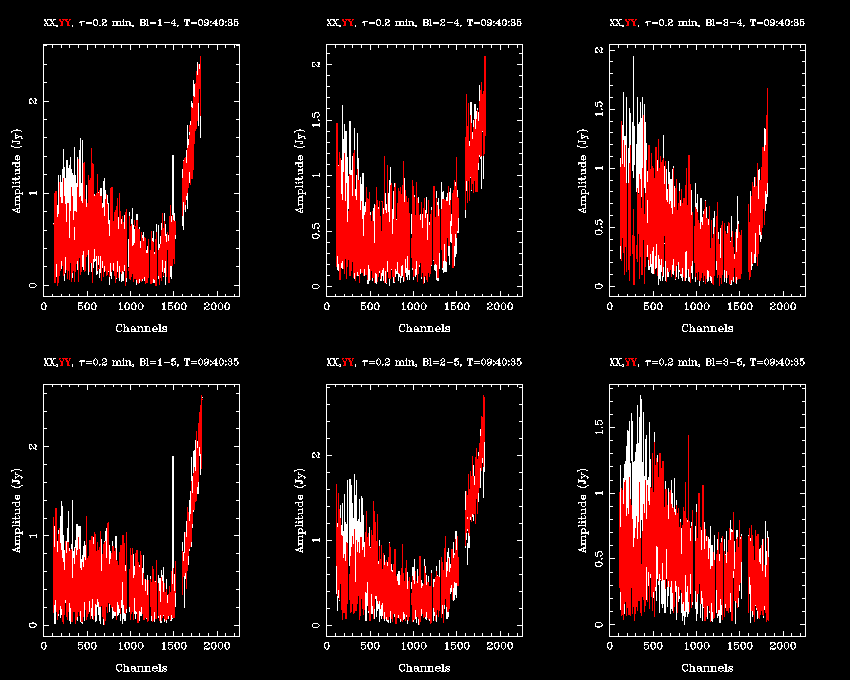

rm: 1323-611.2100_reduction/1323-611.2100_postblflag.png*: No such file or directory
##########Check if source is resolved##########
uvplt: Revision 1.18, 2014/05/21 04:34:59 UTC

Will plot unflagged data

Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100


File # 1  = 1323-611.2100
1323-611.2100 3.1240 GHz
Read 330 visibilities from all files

Plot 330 points


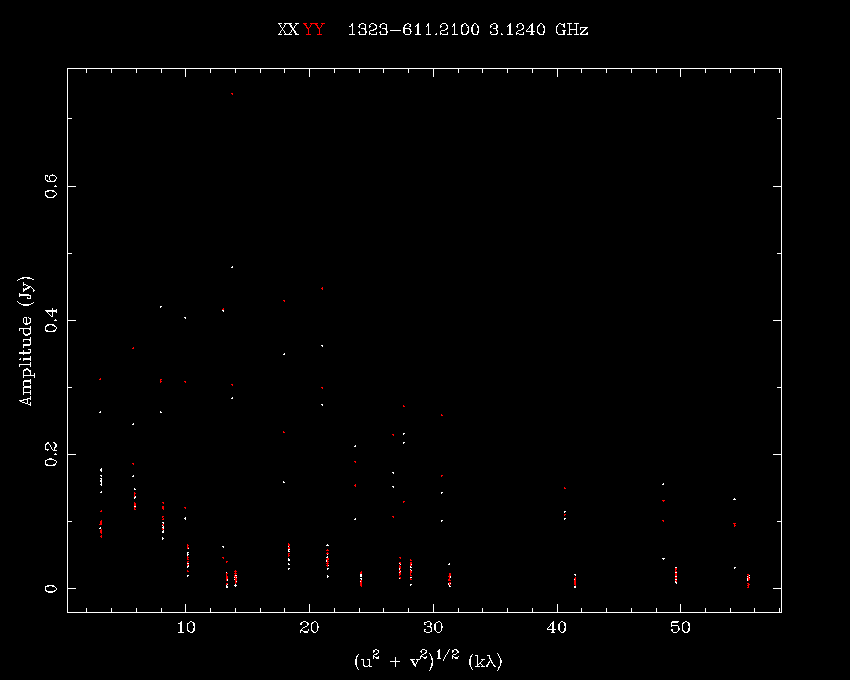

rm: 1323-611.2100_reduction/1323-611.2100_uvdistamp.png*: No such file or directory


In [411]:
# do this 2 or 3 times
loop = [0,1]

for l in loop: 

    # RFI FLAGGING

    # loop over stokes
    stokes_arr = ['xx','xy','yx','yy']

    for u in stokes_arr:
        # pgflag parameters
        vis = source
        stokes = str(u)+','+','.join(stokes_arr)
        command = "<b"
        device="/xs" 
        options="nodisp"
        mir_output = miriad.pgflag(vis=vis,stokes=stokes,command=command,
                            options=options, device=device)
        flagging_check = flaggingcheck_pgflag(mir_output)
        log_it(log_name,"pgflag", mir_output+'\n'+flagging_check[1])
        # add flagging_check[0] to df
        if display_results:
            print(mir_output.decode("utf-8", errors="replace"))
            print(flagging_check)


    # blflag parameters
    vis = source
    device="/xs" 
    stokes = "xx,yy"
    axis = "chan,amp"
    options="nofqav,nobase,selgen"
    mir_output = miriad.blflag(vis=vis,device=device,stokes=stokes,
                               axis=axis,options=options)
    print(mir_output.decode("utf-8"))
    log_it(log_name,"blflag", mir_output)

    # save flagging log
    log = "blflag.select{0}".format(l)
    !mv $log $dir_name      

    
phasecal_df.set_value(h, 'percent_flagged', flagging_check[0])    
# if you want to see what it looks like after blflag
print('#'*10+"Post blflag source"+'#'*10)
# uvspec parameters
vis = source
stokes = "xx,yy"
axis = "chan,amp"
#device="/xs"
device="{0}_postblflag.png/png".format(vis)
mir_output = miriad.uvspec(vis=vis,stokes=stokes,axis=axis,
                            device=device)

move_and_display_pngs(device,dir_name,log=None, display_results)

# done RFI flagging the source
# now apply the calibration solutions

print('#'*10+"Check if source is resolved"+'#'*10)
# look at the amplitude vs time

# uvplt
vis = source
stokes = "xx,yy"
axis = "uvdistance,amplitude"
options="nobase"
device="{0}_uvdistamp.png/png".format(vis)

mir_output = miriad.uvplt(vis=vis,stokes=stokes,axis=axis,
                          options=options,device=device)
print(mir_output.decode("utf-8"))

move_and_display_pngs(device,dir_name,log=None, display_results)

In [412]:
# gpcal parameters
vis =  source
interval="0.1"
nfbin="4"
options="xyvary"

mir_output = miriad.gpcal(vis=vis,interval=interval,nfbin=nfbin,
                           options=options)

log_it(log_name,"gpcal", mir_output)
        
if display_results:
    print(mir_output.decode("utf-8"))

# reestablish flux

# gpboot parameters
vis = source
cal = bandflux_cal

mir_output = miriad.gpboot(vis=vis,cal=cal)
log_it(log_name,"gpboot", mir_output)
        
if display_results:
    print(mir_output.decode("utf-8"))

gpcal: Revision 1.22, 2016/05/01 22:31:05 UTC

Applying bandpass corrections to 1323-611.2100
Number of antennae: 6
Using leakage parameters from input as initial guess
Reading the data ...
Number of solution intervals: 11
Total visibilities read: 165
Number visibilities accepted: 165
Iter= 1, Amplit/Phase Solution Error:   1.001
Iter= 1, Polarisation Solution Error:  -1.000
I flux density:   0.2423
Leakage terms:
 Ant 1:Dx,Dy = ( 0.01520, 0.00290),(-0.01528, 0.00193)
 Ant 2:Dx,Dy = ( 0.01515,-0.00445),(-0.01642,-0.00541)
 Ant 3:Dx,Dy = (-0.02090, 0.00511),( 0.01395, 0.00020)
 Ant 4:Dx,Dy = (-0.00379,-0.00095),( 0.00222,-0.00206)
 Ant 5:Dx,Dy = (-0.00793, 0.00372),( 0.00604, 0.00398)
 Ant 6:Dx,Dy = (-0.00455,-0.00292),( 0.00266,-0.00206)
Solution for freq bin  1
Iter= 1, Amplit/Phase Solution Error:   1.246
Iter= 1, Polarisation Solution Error:  -1.000
I flux density:   0.5818
Leakage terms:
 Ant 1:Dx,Dy = ( 0.01520, 0.00290),(-0.01528, 0.00193)
 Ant 2:Dx,Dy = ( 0.01515,-0.00445),(-0.0

/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'gpcal':  It is unwise to omit OPTION=QUSOLVE when flux is unknown
 Scatter in estimating XY phase for antenna 1 was  29 degrees
 Scatter in estimating XY phase for antenna 2 was  36 degrees
 Scatter in estimating XY phase for antenna 4 was  19 degrees
 Scatter in estimating XY phase for antenna 5 was  47 degrees
 Scatter in estimating XY phase for antenna 6 was  35 degrees
 Scatter in estimating XY phase for antenna 1 was  62 degrees
 Scatter in estimating XY phase for antenna 2 was  58 degrees
 Scatter in estimating XY phase for antenna 4 was  27 degrees
 Scatter in estimating XY phase for antenna 5 was  55 degrees
 Scatter in estimating XY phase for antenna 6 was  84 degrees
 Scatter in estimating XY phase for antenna 1 was  83 degrees
 Scatter in estimating XY phase for antenna 2 was  64 degrees
 Scatter in estimating XY phase for antenna 4 was  67 degrees
 Scatter in estimating XY phase for ant

## uvmeas

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC

uvfmeas: Revision 1.21, 2014/09/22 01:33:27 UTC                         3-t0
Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100
Source: 1323-611
Stokes I
Vector Average Amplitude:  -2.053E-03         Phase:   1.679E-02
             Uncertainty:   2.737E+00
Scalar Average Amplitude:   4.934E-01   Uncertainty:   3.503E+00
--------------------------------------------------------------------------------


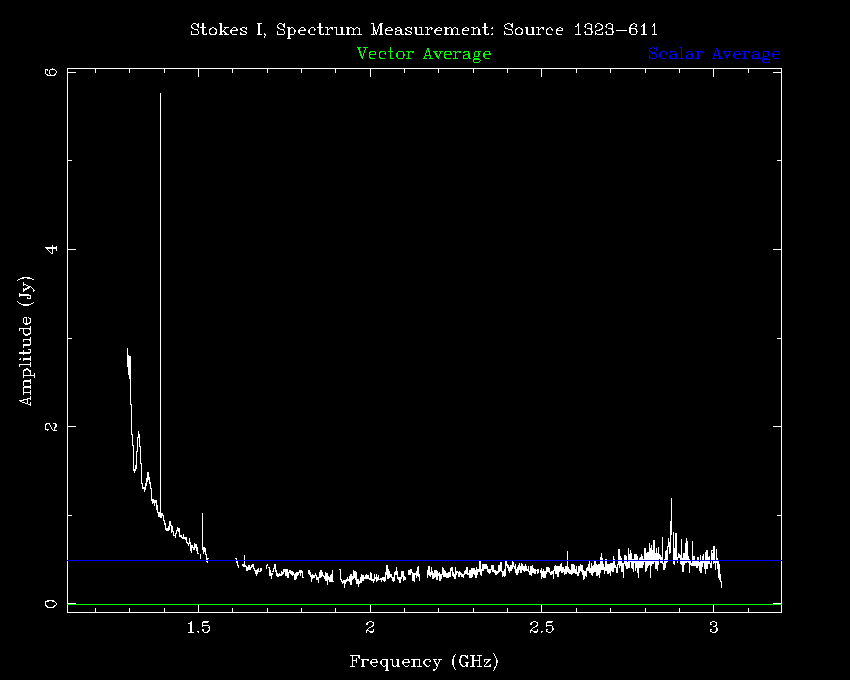

rm: 1323-611.2100_reduction/1323-611.2100_postcaluvmeas.png*: No such file or directory


In [413]:
# uvfmeas!
vis= source
stokes ='i'
line = 'channel,2048,1,1,1'
log = 'uvfmeaslog{0}MHz_{1}'.format(line.split(',')[-2],source)
device="{0}_postcaluvmeas.png/png".format(source)
feval="2.1"

mir_output = miriad.uvfmeas(vis=vis,stokes=stokes,device=device,line=line,
                            feval=feval,log=log)
log_it(log_name,"uvfmeas", mir_output)
        
if display_results:
    print(mir_output.decode("utf-8", errors='replace'))

move_and_display_pngs(device,dir_name,log, display_results)


flux_uvfmeas = grabflux_uvfmeas(mir_output) 
phasecal_df.set_value(h, 'flux', flux_uvfmeas)  

# Imaging

In [414]:
# average/smoothe antenna gains


# gpaver parameters
vis = source
interval = "2"

mir_output = miriad.gpaver(vis=vis,interval=interval)
print(mir_output.decode("utf-8"))


# uvaver parameters
vis = source
temp = vis.split('.')
uvav_source = temp[0]+'.uvaver.'+temp[1]
out= uvav_source 

# remove it if it already exists
!rm -r $out

mir_output = miriad.uvaver(vis=vis,out=out)
print(mir_output.decode("utf-8"))

# split into smaller frequency chunks

# uvsplit parameters
vis = uvav_source 
maxwidth ="0.512"

# how do I predict these file names? 
splitname = source +'.*'
!rm -r $splitname

mir_output = miriad.uvsplit(vis=vis,maxwidth=maxwidth)
print(mir_output.decode("utf-8"))

freq_chunks = names_uvsplit(mir_output)

gpaver: Revision 1.4, 2015/10/29 01:31:20 UTC
rm: 1323-611.uvaver.2100: No such file or directory
UvAver: version 1.0 17-Nov-08
Applying bandpass corrections to 1323-611.2100
Applying freq. dependent gain corrections to 1323-611.2100
Applying freq. dependent leakage correction to 1323-611.2100
rm: 1323-611.2100.*: No such file or directory
uvsplit: Revision 1.18, 2016/05/09 03:06:18 UTC

Creating 1323-611.2868
Creating 1323-611.2356
Creating 1323-611.1844
Creating 1323-611.1332


In [415]:
"""# delete imap & beam if you've cleaned too much and want to start over
rmtext = freq_chunks[i]+".imap" +' '+ freq_chunks[i]+".ibeam"
!rm -r $rmtext"""

'# delete imap & beam if you\'ve cleaned too much and want to start over\nrmtext = freq_chunks[i]+".imap" +\' \'+ freq_chunks[i]+".ibeam"\n!rm -r $rmtext'

## Initial Imaging

rm: 1323-611.2868.imap: No such file or directory
rm: 1323-611.2868.ibeam: No such file or directory
invert: Revision 1.22, 2016/01/20 03:03:49 UTC

Reading the visibility data ...
Making MFS images
Visibilities accepted: 48824
Mean Frequency(GHz):     2.81
Sidelobe suppression area is 2240x4067 arcsec
 ... this corresponds to uniform weighting
Calculating the weights ...
Applying the weights ...
Theoretical rms noise: 5.638E-04
Forming the beam ...
Finished gridding  50% ...
Forming Stokes I  image ...
Completed 100% !
cgdisp: Revision 1.27, 2015/07/09 23:25:48 UTC

Character sizes (axes & velocity) are: 1.0, 1.0
Linear x and y scales per mm = 2.784460E-05, 2.784460E-05
Beginning plane   1
Finding image minimum and maximum
Tabulating linear black and white table
##########Dirty Map after inversion##########


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'invert':  Visibilities rejected: 35656
  warnings.warn(msg)
/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'cgdisp':  KeyFin: Parameter beam not used or not exhausted
 KeyFin: Parameter laptyp not used or not exhausted
  warnings.warn(msg)


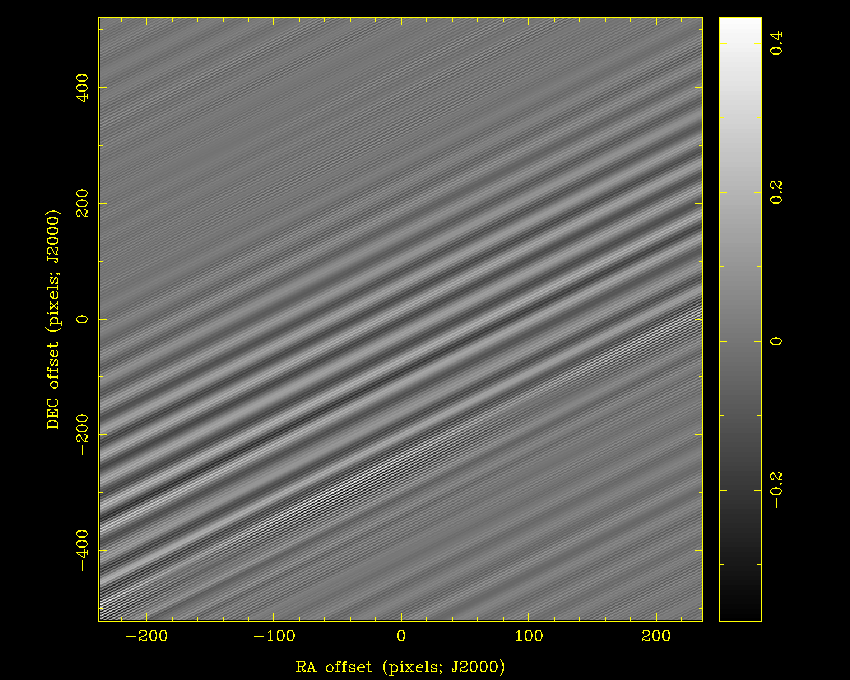

rm: 1323-611.2100_reduction/1323-611.2868.imap_dirtymap.png*: No such file or directory
cgdisp: Revision 1.27, 2015/07/09 23:25:48 UTC

Character sizes (axes & velocity) are: 1.0, 1.0
Linear x and y scales per mm = 5.566254E-05, 5.566254E-05
Beginning plane   1
Finding image minimum and maximum
Tabulating linear black and white table
##########beam##########


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'cgdisp':  KeyFin: Parameter laptyp not used or not exhausted
  warnings.warn(msg)


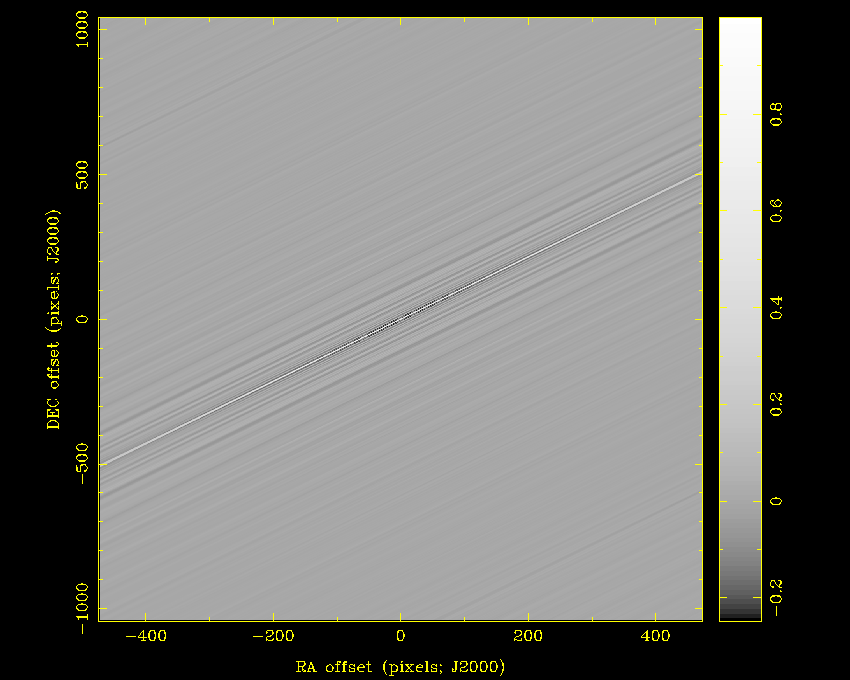

rm: 1323-611.2100_reduction/1323-611.2868.ibeam_dirtybeam.png*: No such file or directory
rm: 1323-611.2868.imodel: No such file or directory
clean: Revision 1.14, 2015/10/29 01:31:02 UTC

Begin iterating
 Clark  Iterations: 1
 Residual min,max,rms:   -3.662E-01   4.333E-01   7.222E-02
 Total CLEANed flux:    4.346E-02
 Clark  Iterations: 2
 Residual min,max,rms:   -3.692E-01   4.048E-01   7.207E-02
 Total CLEANed flux:    8.679E-02
 Clark  Iterations: 3
 Residual min,max,rms:   -3.645E-01   3.940E-01   7.180E-02
 Total CLEANed flux:    1.273E-01
 Clark  Iterations: 4
 Residual min,max,rms:   -3.617E-01   3.901E-01   7.157E-02
 Total CLEANed flux:    1.667E-01
 Clark  Iterations: 5
 Residual min,max,rms:   -3.635E-01   3.873E-01   7.138E-02
 Total CLEANed flux:    2.057E-01
 Clark  Iterations: 6
 Residual min,max,rms:   -3.640E-01   3.613E-01   7.130E-02
 Total CLEANed flux:    2.444E-01
 Clark  Iterations: 8
 Residual min,max,rms:   -3.647E-01   3.623E-01   7.103E-02
 Total CLEANed fl

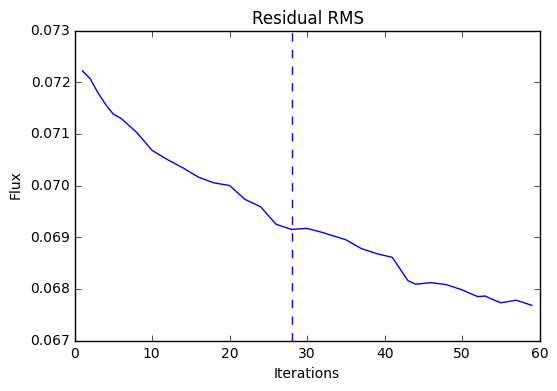

rm: 1323-611.2868.irestor: No such file or directory


/Users/mmcintosh/anaconda/lib/python3.4/site-packages/mirpy/wrapper.py:83: UserWarning: 'restor':  Zero length value for keyword mode
  warnings.warn(msg)


MiriadError: Beam fit failed - beam too elongated


In [416]:
# Imaging

# select the first freq chunk
freq_chunk = freq_chunks[0]

# do I need to image each frequency chunk? 
#for freq_chunk in freq_chunks:
#    print(freq_chunk)

# loop twice so you can use self-cal
loop = [0,1]

for l in loop:
    
    if l == 1:
        ##########################################################################
        # self calibration
        print('#'*10+"Selfcal"+"#"*10)
        # selfcal parameters
        vis = freq_chunk
        model=vis+".imodel"
        clip= "0.013"
        interval=1
        options="phase,mfs"
        
        try: 
            mir_output = miriad.selfcal(vis=vis,model=model,clip=clip,interval=interval,
                                       options=options)
            print(mir_output.decode("utf-8"))
        except:
            print("couldn't self-cal")
        ###########################################################################


    # invert parameters
    vis = freq_chunk
    map_ = freq_chunk+".imap"
    beam = freq_chunk+".ibeam"
    robust = "0.5"
    stokes = "i"
    options="mfs,double"

    # delete the files if they already exist
    !rm -r $map_
    !rm -r $beam

    mir_output = miriad.invert(vis=vis,map=map_,beam=beam,robust=robust,
                               stokes=stokes, options=options)
    print(mir_output.decode("utf-8"))


    invert_rms = grabrms_invert(mir_output)

    # look at the dirty map
    
# dirty map
    # cgdisp parameters
    in_ = freq_chunk+".imap"
    beam = freq_chunk+".ibeam"
    type_="p"
    device="{0}_dirtymap.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                               options=options)
    print(mir_output.decode("utf-8"))
    print('#'*10+"Dirty Map after inversion"+"#"*10)
    move_and_display_pngs(device,dir_name,log=None)

    
# Dirty beam
    # cgdisp parameters
    in_= freq_chunk+".ibeam"
    type_="p"
    device="{0}_dirtybeam.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"
    range_="0,0,log"

    mir_output = miriad.cgdisp(in_=in_,type=type_,device=device,laptyp=laptyp,
                               options=options,range=range_)
    print(mir_output.decode("utf-8"))
    print('#'*10+"beam"+"#"*10)
    move_and_display_pngs(device,dir_name,log=None)



    # clean parameters
    map_ = freq_chunk+".imap"
    beam = freq_chunk+".ibeam"
    out = freq_chunk+".imodel"
    options="negstop,positive"
    cutoff=invert_rms
    niters="1000"

    # remove model if it already exists
    !rm -r $out

    mir_output = miriad.clean(map=map_,beam=beam,out=out,cutoff=cutoff,niters=niters,
                               options=options)
    print(mir_output.decode("utf-8"))


    rmscheck_clean(mir_output) 

    # I should go back and make these plot better

    # restore the image

    # restor parameters
    model = freq_chunk+".imodel"
    beam = freq_chunk+".ibeam"
    map_ = freq_chunk+".imap"
    out = freq_chunk+".irestor"
    mode=""#"residual"

    # remove restored image if it already exists
    !rm -r $out

    mir_output = miriad.restor(model=model,map=map_,beam=beam,out=out, mode=mode)
    print(mir_output.decode("utf-8"))

    # look at the cleaned image

    

    # cgdisp parameters
    in_ = freq_chunk+".irestor"
    beam = freq_chunk+".ibeam"
    type_="p"
    device="{0}_cleanedimage.png/png".format(in_)
    laptyp = "/hms,dms"
    options="wedge"
    range_="0,0,log"

    mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                               options=options,range=range_)
    print(mir_output.decode("utf-8"))
    print('#'*10+"Cleaned image"+"#"*10)
    move_and_display_pngs(device,dir_name,log=None)
    
    # put it in notebook dir
    im_to_save = '{0}_cleanedimage.png'.format(in_)
    !cp $im_to_save $notebook_dir

## Additional Cleaning

## Imfit and imhist

In [ ]:
# measure the flux density of the source

# imfit parameters
in_ = freq_chunk+".irestor"
region="quarter"
object_="point"
spar="1,0,0"
out=freq_chunk+".iresidual"
options="residual"

# remove residual image if it already exists
!rm -r $out

mir_output = miriad.imfit(in_=in_,region=region,object=object_,spar=spar, out=out,
                           options=options)
print(mir_output.decode("utf-8"))


peakflux= grabpeak_imfit(mir_output)



# look at the cleaned image after the central source is subtracted by imfit



# cgdisp parameters
in_ = freq_chunk+".iresidual"
beam = freq_chunk+".ibeam"
type_="p"
device="{0}_cleanedsubtracted.png/png".format(in_)
laptyp = "/hms,dms"
options="wedge"
range_="0,0,log"

mir_output = miriad.cgdisp(in_=in_,beam=beam,type=type_,device=device,laptyp=laptyp,
                           options=options,range=range_)
print(mir_output.decode("utf-8"))
print('#'*10+"Cleaned image - central source"+"#"*10)
move_and_display_pngs(device,dir_name,log=None, display_results)


# estimate the dynamic range of the image

# imhist parameters
in_ = freq_chunk+".iresidual"
region="quarter"
device="{0}_imhist.png/png".format(in_)
options="nbin,100"

mir_output = miriad.imhist(in_=in_,region=region, device=device,
                           options=options)
print(mir_output.decode("utf-8"))
print('#'*10+"imhist"+"#"*10)
move_and_display_pngs(device,dir_name,log=None, display_results)


rms_imhist= grabrms_imhist(mir_output)

dynamic_range = float(peakflux[0])/float(rms_imhist)
print('dynamic range: {0}'.format(round(dynamic_range)))

In [ ]:
# above 300 is good for dynamic range

# clean up
#!rm *png*

# The End!

In [ ]:
# gives a chance for all the images to generate so I can save to html
# no idea why its so tempermental
time.sleep(60)

In [ ]:
# save as HTML
## double check this renders the last cells
save_notebook()
filename = notebook_dir+'/mirpy_reducescript.ipynb'


fn = export_to_html(filename,source)
time.sleep(20)

if os.path.isfile(filename):
    print("File exported as:\n\t{0}".format(fn))
    print(time.strftime("%d/%m/%Y"))
else:
    # try again
    time.sleep(20)
    fn = export_to_html(filename,source)

In [ ]:
# if I'm not paying attention

applescript = """
display dialog "Mirpy script finished!" ¬
with title "Juypter notebook" ¬
with icon caution ¬
buttons {"OK"}
"""
subprocess.call("osascript -e '{0}'".format(applescript), shell=True)